In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import sklearn
# Any results you write to the current directory are saved as output.

['train', 'test', 'train_labels.csv', 'sample_submission.csv']


# Load in the training dataset

In [61]:
train_labels = pd.read_csv('../input/train_labels.csv')
print(train_labels.iloc[:3,:])

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0


# Explore the data, visualize the cancer and benign cell images

In [62]:
# Find the first 6 images without cancer cells
benigns = []
i = 0
while len(benigns) < 6:    
    if train_labels.iloc[i,1] == 0:
        benigns.append(train_labels.iloc[i,0])
    i += 1

In [63]:
# Find the first 6 images with cancer cells
cancers = []
i = 0
while len(cancers) < 6:    
    if train_labels.iloc[i,1] == 1:
        cancers.append(train_labels.iloc[i,0])
    i += 1

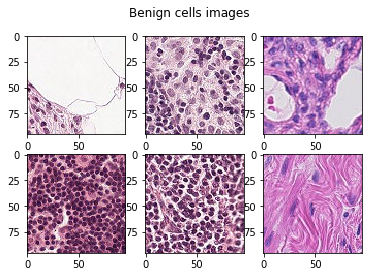

In [64]:
# Visualize the images without cancer cells in RGB format
# read in the first image
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.suptitle('Benign cells images')
i = 0
for row in ax:
    for col in row:        
        sample1 = cv2.imread('../input/train/'+ '%s' % benigns[i] +'.tif')
        sample1 = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
        img1 = Image.fromarray(sample1,'RGB')
        col.imshow(img1)
        i += 1
        #col.plot(x, y)

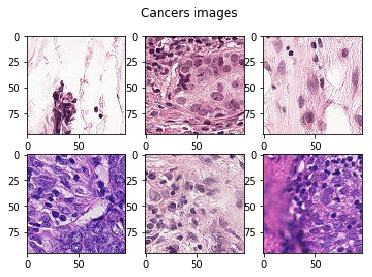

In [65]:
# Visualize the images with cancer cells in RGB format
fig, ax = plt.subplots(nrows=2, ncols=3)
fig.suptitle('Cancers images')
i = 0
for row in ax:
    for col in row:        
        sample2 = cv2.imread('../input/train/'+ '%s' % cancers[i] +'.tif')
        sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
        img2 = Image.fromarray(sample2,'RGB')
        col.imshow(img2)
        i += 1

In [33]:
# Find the shape of each image
sample2.shape

(96, 96, 3)

In [34]:
# Explore the classes
print('There are ', len(train_labels[train_labels['label']==0]), ' training samples in the 0 class.')
print('There are ', len(train_labels[train_labels['label']==1]), ' training samples in the 1 class.')

There are  130908  training samples in the 0 class.
There are  89117  training samples in the 1 class.


### The training dataset is not strictly balanced. The ratio for benign samples to cancer samples is about 1.5 : 1.

# Preprocessing the training data

In [42]:
# Stack images into one numpy array
# Read in images batch by batch
def preprocessing(start, end):
    file_name = train_labels.iloc[start,0]
    sample1 = cv2.imread('../input/train/'+ '%s' % file_name +'.tif')
    sample1 = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
    X_train = sample1
    Y_train = [[train_labels.iloc[0,1]]]
    idx = start+1
    for file in train_labels.iloc[start+1:end,0]:
        img = cv2.imread('../input/train/'+ '%s' % file +'.tif')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_train = np.concatenate([X_train,img])
        Y_train.extend([[train_labels.iloc[idx,1]]])
        idx += 1
    X_train = np.reshape(X_train,(-1,96,96,3))
    X_train = 2.0*(X_train / 255) - 1.0
    return X_train, Y_train

In [43]:
# Test the preprocessing function with first 10 training data
train_filenames = train_labels.iloc[:,0]
X_train,Y_train = preprocessing(0, 10)
X_train.shape

(10, 96, 96, 3)

In [44]:
# Convert the binary labels into one-hot format
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(np.array(Y_train))
out = enc.transform(Y_train).toarray()
print(out)
print(train_labels.iloc[:10,1])

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]
0    0
1    1
2    0
3    0
4    0
5    0
6    1
7    1
8    0
9    0
Name: label, dtype: int64


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


# Build the multi-scale CNN 

In [45]:
def MultiScaleCNNArchV2(x, dropout):
    """
    See "Traffic Sign Recognition with MultiScale Convolutional Neural Networks" by Sermanet, 2011.
    See also https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad.
    I re-implemented an architecture similar to the ones described by Yadav and Sermanet. 
    """
    mu = 0
    sigma = 0.05

    ##CONVOLUTION LAYER 1
    #Weights for layer 1
    w_1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
    #Bias for layer 1
    b_1 = tf.Variable(tf.constant(0.0, shape=[[11,11,3,96][3]]))
    #Applying convolution
    c_1 = tf.nn.conv2d(x, w_1,strides=[1, 2, 2, 1], padding='VALID')
    #Adding bias
    c_1 = c_1 + b_1
    #Applying RELU
    c_1 = tf.nn.relu(c_1)
    ##POOLING LAYER1
    p_1 = tf.nn.max_pool(c_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')

    ##CONVOLUTION LAYER 2
    #Weights for layer 2
    w_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
    #Bias for layer 2
    b_2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))
    #Applying convolution
    c_2 = tf.nn.conv2d(p_1, w_2,strides=[1, 1, 1, 1], padding='SAME')
    #Adding bias
    c_2 = c_2 + b_2
    #Applying RELU
    c_2 = tf.nn.relu(c_2)
    ##POOLING LAYER2
    p_2 = tf.nn.max_pool(c_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
    
    ##CONVOLUTION LAYER 3
    #Weights for layer 3
    w_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
    #Bias for layer 3
    b_3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))
    #Applying convolution
    c_3 = tf.nn.conv2d(p_2, w_3,strides=[1, 1, 1, 1], padding='SAME')
    #Adding bias
    c_3 = c_3 + b_3
    #Applying RELU
    c_3 = tf.nn.relu(c_3)
    
    ##CONVOLUTION LAYER 4
    #Weights for layer 4
    w_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
    #Bias for layer 4
    b_4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))
    #Applying convolution
    c_4 = tf.nn.conv2d(c_3, w_4,strides=[1, 1, 1, 1], padding='SAME')
    #Adding bias
    c_4 = c_4 + b_4
    #Applying RELU
    c_4 = tf.nn.relu(c_4)

    ##CONVOLUTION LAYER 5
    #Weights for layer 5
    w_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
    #Bias for layer 5
    b_5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))
    #Applying convolution
    c_5 = tf.nn.conv2d(c_4, w_5,strides=[1, 1, 1, 1], padding='SAME')
    #Adding bias
    c_5 = c_5 + b_5
    #Applying RELU
    c_5 = tf.nn.relu(c_5)
    ##POOLING LAYER3
    p_3 = tf.nn.max_pool(c_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 13: Combining layers 4, 8, and 12 into one flattened layer.
    # Input = 16x16x32, 8x8x64, 4x4x128. Output = 1x14336
    flat_layer1 = tf.contrib.layers.flatten(p_1)
    flat_layer2 = tf.contrib.layers.flatten(p_2)
    flat_layer3 = tf.contrib.layers.flatten(p_3)
    #Flattening
    #flattened = tf.reshape(p_3,[-1,4*4*256])
    flattened= tf.concat([flat_layer1, flat_layer2, flat_layer3], axis=1)
    # Layer 14: Fully Connected. Input = 1x14336. Output = 1x1024
    input_size = int( flattened.get_shape()[1] )
    #Weights for FC Layer 1
    w1_fc = tf.Variable(tf.truncated_normal([input_size, 2048], stddev=0.01))
    #Bias for FC Layer 1
    b1_fc = tf.Variable( tf.constant(1.0, shape=[2048] ) )
    #Summing Matrix calculations and bias
    s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
    #Applying RELU
    s_fc1 = tf.nn.relu(s_fc1)
    #Dropout Layer 1
    hold_prob1 = tf.placeholder(tf.float32)
    s_fc1 = tf.nn.dropout(s_fc1,keep_prob=dropout)
    
    ##Fully Connected Layer 2
    #Weights for FC Layer 2
    w2_fc = tf.Variable(tf.truncated_normal([2048, 1024], stddev=0.01))
    #Bias for FC Layer 2
    b2_fc = tf.Variable( tf.constant(1.0, shape=[1024] ) )
    #Summing Matrix calculations and bias
    s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
    #Applying RELU
    s_fc2 = tf.nn.relu(s_fc2)
    #Dropout Layer 2
    hold_prob2 = tf.placeholder(tf.float32)
    s_fc2 = tf.nn.dropout(s_fc2,keep_prob=dropout)
    
    ##Fully Connected Layer 3
    #Weights for FC Layer 3
    w3_fc = tf.Variable(tf.truncated_normal([1024,2], stddev=0.01))
    #Bias for FC Layer 3b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
    b3_fc = tf.Variable( tf.constant(1.0, shape=[2] ) )
    #Summing Matrix calculations and bias
    y_pred = tf.matmul(s_fc2, w3_fc) + b3_fc    
    
    regularizers = (tf.nn.l2_loss(w_1)
                    + tf.nn.l2_loss(w_2) + tf.nn.l2_loss(w_3)
                    + tf.nn.l2_loss(w_4) + tf.nn.l2_loss(w_5)
                    + tf.nn.l2_loss(w1_fc) + tf.nn.l2_loss(w2_fc)
                    + tf.nn.l2_loss(w3_fc))
                    
    return y_pred, regularizers

In [46]:
# Hyperparameters
EPOCHS = 40
BATCH_SIZE = 128
rate = 0.00005
dropout = 0.50
#Resetting graph
tf.reset_default_graph()
#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,96,96,3])
y_true = tf.placeholder(tf.float32,shape=[None,2])
keep_prob = tf.placeholder(tf.float32)
logits, regularizers = MultiScaleCNNArchV2(x, keep_prob)
#Defining loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true,logits=logits))
#Defining objective
train = tf.train.AdamOptimizer(learning_rate=rate).minimize(cross_entropy)

#Defining Accuracy
matches = tf.equal(tf.argmax(logits,1),tf.argmax(y_true,1))
acc = tf.reduce_mean(tf.cast(matches,tf.float32))

#Initializing weights
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Choose the last 5025 training data as the validation data

In [47]:
# Use the last 5025 training data as the validation data
validate_x,validate_y = preprocessing(215000,220025)
validate_y = enc.transform(validate_y).toarray()

# Train the model with 215000 training data

In [48]:
#Starting Empty lists to keep results
acc_list = []
auc_list = []
loss_list = []

In [50]:
from sklearn.metrics import roc_auc_score  
#GPU settings
max_accuracy = 0.0
epochs = 30
BATCH_SIZE = 128
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
with tf.Session(config=config) as sess:
    sess.run(init)
    num_examples = 215000
    for i in range(epochs):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE            
            batch_x, batch_y = preprocessing(offset,end)
            batch_y = enc.transform(batch_y).toarray()
            batch_x, batch_y = sklearn.utils.shuffle(batch_x, batch_y)
            #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
            _,c = sess.run([train,cross_entropy],
                           feed_dict={x:batch_x , y_true:batch_y, keep_prob: 0.5})
        #Writing for loop to calculate test statistics. GTX 1050 isn't able to calculate all test data.
        cv_auc_list = []
        cv_acc_list = []
        cv_loss_list = []
        for v in range(0,len(validate_y)-int(len(validate_y) % 128),128):
            acc_on_cv,loss_on_cv,preds = sess.run([acc,cross_entropy,tf.nn.softmax(logits)],
                                                  feed_dict={x:validate_x[v:v+128] ,y_true:validate_y[v:v+128] , 
                                                             keep_prob: 1.0})
            auc_on_cv = roc_auc_score(validate_y[v:v+128],preds)
            cv_acc_list.append(acc_on_cv)
            cv_auc_list.append(auc_on_cv)
            cv_loss_list.append(loss_on_cv)
        acc_cv_ = round(np.mean(cv_acc_list),5)
        auc_cv_ = round(np.mean(cv_auc_list),5)
        loss_cv_ = round(np.mean(cv_loss_list),5)
        acc_list.append(acc_cv_)
        auc_list.append(auc_cv_)
        loss_list.append(loss_cv_)
        print("Epoch:",i+1,"Accuracy:",acc_cv_,"Loss:",loss_cv_ ,"AUC:",auc_cv_)
        if acc_cv_ > max_accuracy:  # save only highest accuracy we've achieved so far
            max_accuracy = acc_cv_
            saver.save(sess, './best_model_save_file')            
            print("Highest accuracy seen so far. Model saved.")            
        else:
            print("Not highest accuracy seen so far. Model not saved.")
        

Epoch: 1 Accuracy: 0.60136 Loss: 0.65834 AUC: 0.76833
Highest accuracy seen so far. Model saved.
Epoch: 2 Accuracy: 0.60136 Loss: 0.64014 AUC: 0.80569
Not highest accuracy seen so far. Model not saved.
Epoch: 3 Accuracy: 0.71014 Loss: 0.57089 AUC: 0.80839
Highest accuracy seen so far. Model saved.
Epoch: 4 Accuracy: 0.76703 Loss: 0.50838 AUC: 0.82719
Highest accuracy seen so far. Model saved.


KeyboardInterrupt: 

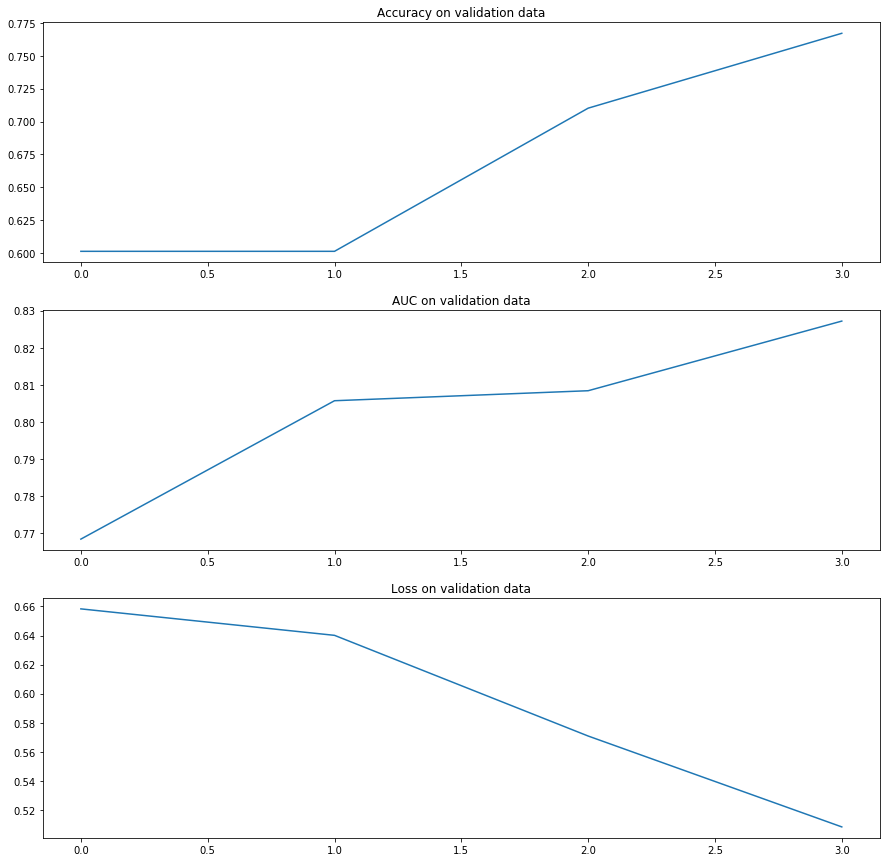

In [59]:
# Visualize the training process through accuracy, loss and AUC on the validation data
f,ax=plt.subplots(3,1,figsize=(15,15))
pd.Series(acc_list).plot(kind='line',title='Accuracy on validation data',ax=ax[0])
pd.Series(auc_list).plot(kind='line',title='Loss on validation data',ax=ax[1])
pd.Series(loss_list).plot(kind='line',title='AUC on validation data',ax=ax[2])
plt.subplots_adjust(wspace=1)
ax[0].set_title('Accuracy on validation data')
ax[1].set_title('AUC on validation data')
ax[2].set_title('Loss on validation data')
plt.show()

# Load the test data and use the model to predict

In [ ]:
# Load the test data
test_labels = pd.read_csv('../input/sample_submission.csv')
test_filenames = test_labels.iloc[:,0]
# Explore the classes
print('There are ', len(test_labels[test_labels['label']==0]), ' test samples in the 0 class.')
print('There are ', len(test_labels[test_labels['label']==1]), ' test samples in the 1 class.')

In [ ]:
# Predict the test data with probabilities
softmax_logits = tf.nn.softmax(logits)

predictions = []
num_examples = test_labels.shape[0]
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('best_model_save_file.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./'))
    for offset in range(0, num_examples):
            end = offset + 1
            file_name = test_labels.iloc[offset,0]
            img = cv2.imread('../input/test/'+ '%s' % file_name +'.tif')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            batch_x = np.reshape(img,(-1,96,96,3))
            batch_x = 2.0*(batch_x / 255) - 1.0
            pred = sess.run(softmax_logits, feed_dict={x: batch_x, keep_prob: 1.0})
            predictions.append(pred[0,1])

In [ ]:
# Save the prediction to the submission file
test_pred = test_labels.copy(deep=True)
test_pred['label'] = predictions
test_pred.to_csv('submission.csv', index=False)